In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/home/lxy/Documents/python/dogs-vs-cats-small/test/cats/cat.1999.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [2]:
import tensorflow as tf

graph = tf.Graph()
with graph.as_default():
    session = tf.compat.v1.Session()
    with session.as_default():
        ## your load model code
        model = VGG16(weights='imagenet')
        model._make_predict_function()
# save each graph and session value to some variable for later prediction use.
graph_var = graph
session_var = session
with graph_var.as_default():
     with session_var.as_default():
            preds = model.predict(x)

print(decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
[('n02112018', 'Pomeranian', 0.5604406), ('n02123394', 'Persian_cat', 0.32106572), ('n02123159', 'tiger_cat', 0.012538683)]


259

In [7]:
from keras import backend as K

with graph_var.as_default():
    with session_var.as_default():
        pomeranian_output = model.output[:,259]
        last_conv_layer = model.get_layer('block5_conv3')
        grads = K.gradients(pomeranian_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0,1,2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([x])
        
        for i in range(512):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmap = np.mean(conv_layer_output_value, axis=-1)

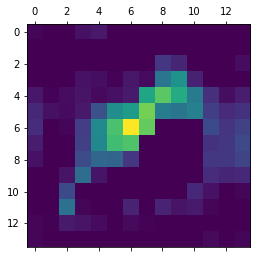

In [8]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [11]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./pomeranian_cam.jpg', superimposed_img)

True